# Bayesian models

In this seminar:

* Make sure all the dependencies are installed and work fine for you
* Look into the lecture example

## Installation
1. Install [Anaconda](https://www.anaconda.com/) or [Mamba](https://github.com/mamba-org/mamba)
    
    * Conda is slow
    * Mamba is fast (I use this one)
    
2. Create an environment for the course

```console
conda env update -f environment.yaml
```

You can find the environment file in the root of the repository

3. Install jupyter kernel for the course

```
conda activate bayes-econ
python -m ipykernel install --user --name bayes-econ
```

In [2]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import statsmodels.api as sm
az.style.use("arviz-white")

## Example 0 - 8 schools

In [3]:
J = 8
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
# lower std for better visualizations
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18]) / 2

$$
\begin{array}{rcl}
            \text{mu} &\sim & \operatorname{N}(0,~5)\\\text{tau} &\sim & \operatorname{C^{+}}(0,~5)\\\text{theta}_i &\sim & \operatorname{N}(\text{mu},~\text{tau})\\\text{obs}_i &\sim & \operatorname{N}(\text{theta},~\sigma_i)
            \end{array}
$$

We'll use 
* `pm.Normal`
* `pm.HalfCauchy`

In [4]:
with pm.Model(coords=dict(J=range(J))) as schools_centered:
    mu = ...
    tau = ...
    theta = ...
    obs = ...

In [5]:
pm.model_to_graphviz(schools_centered)

In [ ]:
schools_centered

   mu ~ N(0, 5)
  tau ~ C**+(0, 5)
theta ~ N(mu, tau)
  obs ~ N(theta, <constant>)

In [ ]:
with schools_centered:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7076, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5309, but should be close to 0.8. Try to increase the number of tuning steps.


## Example 1 - Where Do Priors Come From?

In [ ]:
data = pd.read_csv(
    "https://osf.io/vfjud/download", 
    sep="\t", 
    names=["id", "QF", "sopt1", "sopt2", "sopt3", "sopt4", "cudit1"], 
    na_values="999"
)

In [ ]:
data

,id,QF,sopt1,sopt2,sopt3,sopt4,cudit1
0,1,1.0,75.0000,88.8889,88.8889,NaN,0
1,2,0.0,NaN,NaN,NaN,NaN,0
2,3,2.0,NaN,NaN,NaN,NaN,0
3,4,0.0,NaN,NaN,NaN,NaN,0
4,5,14.0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...
263,186,23.0,NaN,NaN,NaN,NaN,1
264,187,3.0,77.7778,83.3333,NaN,NaN,0
265,189,0.0,77.7778,83.3333,88.8889,91.6667,0
266,190,0.0,NaN,NaN,NaN,NaN,0


> Their "id" variable seem to have duplicates

In [ ]:
long_data = (
    pd.wide_to_long(data.reset_index(), "sopt", "index", "t")
    .reset_index()
    .dropna()
    .assign(t=lambda df: df.t-1)
)
long_data

,index,t,id,QF,cudit1,sopt
0,0,0,1,1.0,0,75.0000
7,7,0,8,0.0,0,75.0000
8,8,0,9,0.0,0,33.3333
9,9,0,10,0.0,0,66.6667
10,10,0,11,0.0,0,58.3333
...,...,...,...,...,...,...
1056,252,3,175,1.0,0,83.3333
1058,254,3,177,0.0,0,61.1111
1061,257,3,180,12.0,0,86.1111
1064,260,3,183,1.0,0,83.3333


## Visualizing data

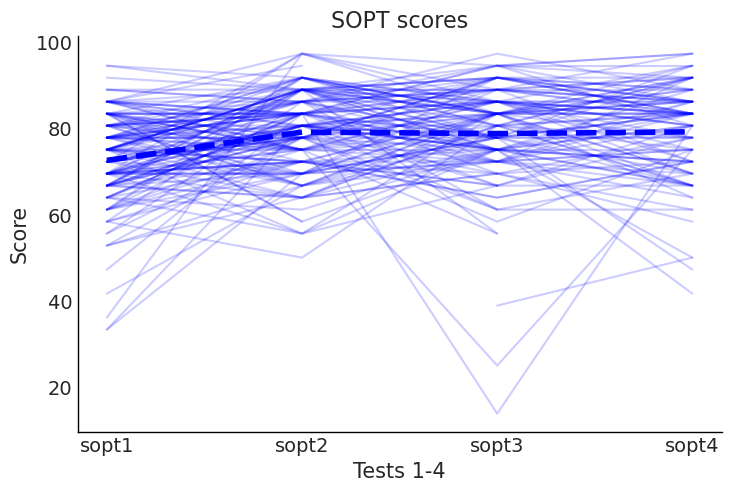

In [ ]:
data.loc[:, "sopt1":"sopt4"].T.plot(legend=False, color="b", alpha=0.2);
avg = data.loc[:, "sopt1":"sopt4"].mean().plot(color="b", linestyle="--", lw=4, label="avg")
plt.title("SOPT scores")
plt.xlabel("Tests 1-4")
plt.ylabel("Score");

The data is split by "CUDIT" variable which splits heavy and light users

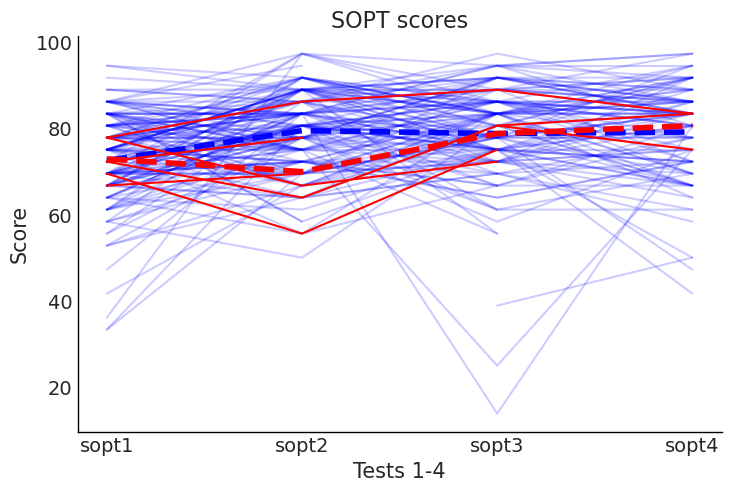

In [ ]:
ax = data.query("cudit1 == 0").loc[:, "sopt1":"sopt4"].T.plot(legend=False, color="blue", alpha=0.2);
data.query("cudit1 == 0").loc[:, "sopt1":"sopt4"].mean().plot(color="blue", linestyle="--", lw=4, label="avg", ax=ax)
data.query("cudit1 == 1").loc[:, "sopt1":"sopt4"].T.plot(legend=False, color="red", alpha=1, ax=ax);
data.query("cudit1 == 1").loc[:, "sopt1":"sopt4"].mean().plot(color="red", linestyle="--", lw=4, label="avg", ax=ax)
plt.title("SOPT scores")
plt.xlabel("Tests 1-4")
plt.ylabel("Score");

## The model

#### Functional form
$$
\text{SOPT}_t = a_1 + a_2 * t + a_3 * t ^ 2
$$

* $a_1$ - intercept
* $a_2$ - linear trend
* $a_3$ - quadratic term, possible decay in growth
* $t$ - $0\dots 3$, periods where measurement was taken

### Priors (by Authors)
$$
\begin{align}
\text{SOPT}_t &\sim \operatorname{Normal}(a_1 + a_2 * t + a_3 * t ^ 2, \sigma)\\
a_1 &\sim \operatorname{Normal}(85, \sqrt{30})\\
a_2 &\sim \operatorname{Normal}(2, \sqrt{7.5})\\
a_3 &\sim \operatorname{Normal}(-0.1, \sqrt{7.5})\\
\sigma &\sim \operatorname{HalfFlat}
\end{align}
$$

> $\sigma$ is the most unclear part of the paper. 
> 
> Authors used MPLUS library whith the following [docs](https://www.rensvandeschoot.com/regression-in-mplus-bayesian/)
> Which advertises $\sigma \sim \operatorname{I-Gamma}(-1, 0)$.
> 
> This is HalfFlat distribution (the most obscure choice)

#### Adding Groups
Groups are added in a very simplistic way

$$
\begin{align}
\text{SOPT}^g_t &\sim \operatorname{Normal}(a^g_1 + a^g_2 * t + a_3 * t ^ 2, \sigma)\\
a^g_1 &\sim \operatorname{Normal}(85, \sqrt{30})\\
a^g_2 &\sim \operatorname{Normal}(2, \sqrt{7.5})\\
a_3 &\sim \operatorname{Normal}(-0.1, \sqrt{7.5})\\
a^0_2 - a^1_2 &\sim \operatorname{Normal}(0, 10)\\
\sigma &\sim \operatorname{HalfFlat}
\end{align}
$$

##### Potential Trick

You can see a non standard interaction
$$
a^0_2 - a^1_2 \sim \operatorname{Normal}(0, 10)
$$
With PyMC this can be incorporated into the model with a Potential.

In [6]:
import itertools
with pm.Model(coords=dict(cudit=["light", "heavy"], period=range(4))) as model:
    # a1 and a2 priors are simple
    # dims="cudit" will notify the model to add extra dims
    a1 = ...
    # coordinates help in visualizations
    a2 = ...
    
    # shared quadratic term
    a3 = ...
    
    # Half Flat sigma (improper prior)
    σ = ...
    # creating a matrix with items (cudit x period)
    # a^g_1 + a^g_2 * t + a_3 * t ^ 2
    estimate = ...
    
    # you can use numpy indexing to get an estimate for each observation obs_{itc}
    long_estimate = ...
    
    observed = ...

In [ ]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, a3, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8826, but should be close to 0.8. Try to increase the number of tuning steps.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

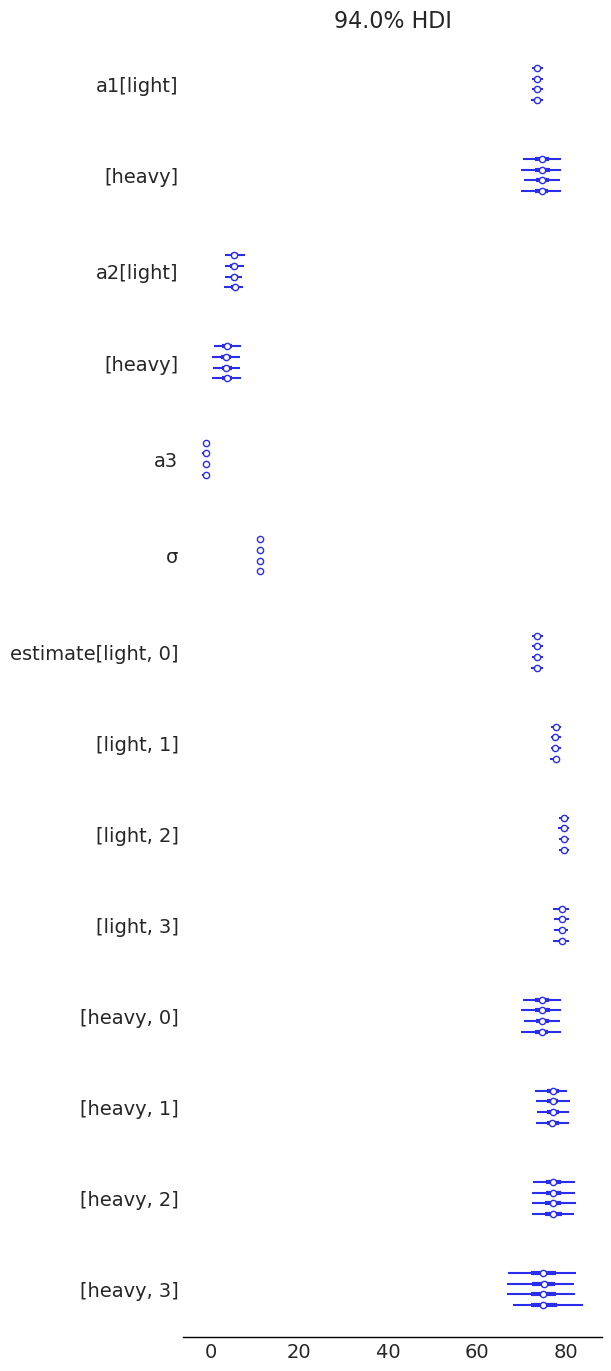

In [ ]:
az.plot_forest(trace)

In [ ]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
me = trace.posterior.estimate.mean(["chain", "draw"])
se = trace.posterior.estimate.std(["chain", "draw"])

In [ ]:
df = trace.posterior.estimate.stack(sample=["chain", "draw"]).to_dataframe()

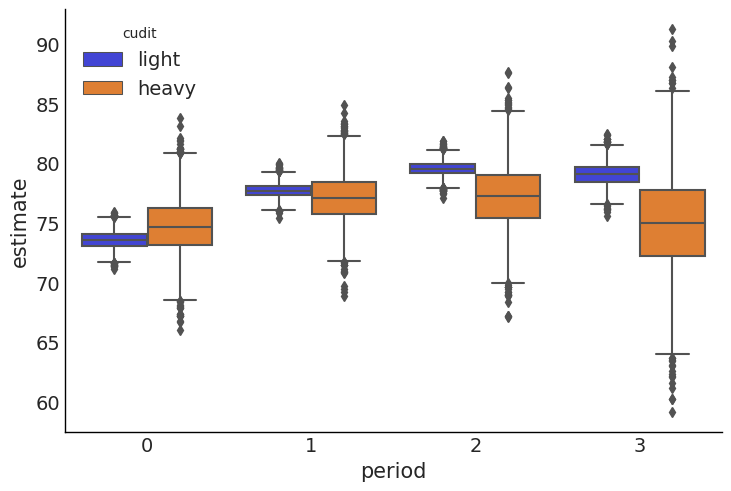

In [ ]:
sns.boxplot(x="period", y="estimate", hue="cudit", data=df.reset_index());